# <img src="https://img.icons8.com/dusk/64/000000/code.png" style="height:50px;display:inline"> Soft-IntroVAE Code Tutorial - Image Datasets
---

Tal Daniel


<center>
    Open in Google Colab
    <a href=""><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
</center>

* Paper: [**Soft-IntroVAE: Analyzing and Improving the Introspective Variational Autoencoder**, Tal Daniel and Aviv Tamar]()
* GitHub: 

### <img src="https://img.icons8.com/color/96/000000/loading.png" style="height:50px;display:inline"> Running Instructions
---
* This Jupyter Notebook can be opened locally with Anaconda, or online via Google Colab.
* To run online, go to https://colab.research.google.com/ and drag-and-drop the `soft_intro_vae_image_code_tutorial.ipynb` file.
    * On Colab, note the "directory" icon on the left, figures and checkpoints are saved in this directory.
* To run the training on the image dataset, it is better to have a GPU. In Google Cola select `Runtime->Change runtime type->GPU`.

### <img src="https://img.icons8.com/bubbles/50/000000/checklist.png" style="height:50px;display:inline"> Agenda
---
* [Variational Autoencoders (VAEs)](#-Variational-Autoencoders-(VAEs))
* [Soft-IntroVAE Objectives](#-Soft-IntroVAE-Objectives)
* [Image Generation Experiments](#-Image-Generation-Experiments)
    * [Image Generation Experiments - Architectures](#Image-Generation-Experiments---Architectures)
    * [Image Generation Experiments - Algorithm and Train Function](#Image-Generation-Experiments---Algorithm-and-Train-Function)
* [More Tutorials](#-But-Wait,-There-is-More...)
* [Credits](#-Credits)

### <img src="https://img.icons8.com/plasticine/100/000000/epsilon.png" style="height:50px;display:inline"> Variational Autoencoders (VAEs)
---
Unlike regular autoencoders, Variational Autoencoder (VAE, <a href="https://arxiv.org/abs/1312.6114">Kingma & Welling, 2014</a>) map the input to a distribution.

In VAE we infer $p_{\theta}(z|X)$ using a method calld **Variational Inference (VI)** (hence the name **Variational** Autoencoder).

**Variational Inference (VI)** - solve an optimization problem in which we model $p_{\theta}(z|X)$ using a simpler distribution, $q_{\phi}(z|x)$, which is easier to evaluate, like a Gaussian, and **minimize the difference between these distributions using the KL-divergence**.

**Evidence Lower BOund (ELBO)** - the optimization problem is to make the simpler distribution, $q_{\phi}(z|X)$ as closer as possible to $p_{\theta}(z|X)$. Using the KL-divergence, the we get the evidence lower bound: $$ \log p_{\theta}(X) \geq \mathbb{E}_{q_{\phi}(z|X)}[\log p_{\theta}(X|z)] - D_{KL}[q_{\phi}(z|X) || p(z)] = ELBO(X; \theta, \phi).$$

$p(z)$ is a prior, independent of the model. In VAE, a common choice for the prior is a simple one $$p(z) \sim \mathcal{N}(0,1).$$

$q_{\phi}(z|X)$ is also called the **encoder** and $p_{\theta}(X|z)$ the **decoder**.

In practice, the ELBO is decomposed to the **reconstruction error** and the KL-divergence, which has a closed-form solution in the Gaussian case.

The optimization is made possible thanks to the **reparameterization trick**, as it allows to backpropagate the gradients through the stochastic latent variable: $$ z \sim q_{\phi}(z|X) = \mathcal{N}(z; \mu, \sigma^2 I) $$ $$ \to z = \mu + \sigma \odot \epsilon, \text{where } \epsilon \sim \mathcal{N}(0, I) $$

<img src="../assets/vae_lilian_weng_lilianweng.github.io.png" style="height:300px">

* <a href="https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#beta-vae">Image by Lilian Weng</a>

### <img src="https://img.icons8.com/fluent/96/000000/rubiks-cube.png" style="height:50px;display:inline"> Soft-IntroVAE Objectives
---
In Soft-IntroVAE, the encoder and decoder are trained to maximize the ELBO for real data (as in standard VAEs), and in addition, we use the exponential of the ELBO (expELBO) to "push away" fake data, generated by the decoder, from the latent space learned by the encoder, while the decoder also tries to pull back its generated data closer to the latent space, hence improving over time.

Comparing to GANs, the discriminatory signal comes from the encoder (the ELBO acts as an energy function), thus, the VAE is trained in an introspective manner (no need for an additional discriminator).

The objective of Soft-IntroVAE is written as follows:

$$ \mathcal{L}_{E_{\phi}}(x,z) = s \cdot(\beta_{rec}\mathcal{L}_r(x) +\beta_{kl}KL(x)) + \frac{1}{2}\exp(-2s\cdot (\beta_{rec}\mathcal{L}_r(D_{\theta}(z)) + \beta_{neg}KL(D_{\theta}(z)))), $$
$$ \mathcal{L}_{D_{\theta}}(x,z) = s \cdot \beta_{rec}\mathcal{L}_r(x) +s \cdot(\beta_{kl}KL(D_{\theta}(z)) +\gamma_r \cdot \beta_{rec}\mathcal{L}_r(D_{\theta}(z))), $$

where $\mathcal{L}_r(x) = - \mathbb{E}_{q_{\phi}(z\mid x)}\left[\log p_{\theta}(x \mid z)\right]$ denotes the reconstruction error, $s$ is a scaling constant which is set to the inverse of the input dimensions, and $\beta_{rec}, \beta_{kl}, \beta_{neg}$ and $\gamma_r$ are hyperparameters. 

Note that in all our experiments the "coeffecient of fake data reconstruction error", $\gamma_r = 1e-8$ (in the bootstrap version in can be set to 1), as setting it to higher values may hold back the decoder and slow down convergence (since at the beginning, the generated data is really bad). Basically, this hyperparamter can be annealed to 1 over time, but for simplicity, we don't do it.

<img src="../assets/sintrovae_flow.PNG" style="height:350px">

## <img src="https://img.icons8.com/office/80/000000/edit-image.png" style="height:50px;display:inline"> Image Generation Experiments
---
In this part, we will demonstrate Soft-IntroVAE on the CIFAR-10 image dataset.

**Fot this part, it highly recommeneded to enable GPU** (instructions at the top if you are running on Google Colab).

In [1]:
# imports for the tutorial
import os
import time
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from torchvision import transforms
import torchvision.utils as vutils

### <img src="https://img.icons8.com/dusk/64/000000/venn-diagram.png" style="height:50px;display:inline">Image Generation Experiments - Architectures
---
This part defines the building blocks of the Soft-IntroVAE.

In [2]:
"""
Helper Functions
"""

def calc_kl(logvar, mu, mu_o=0.0, logvar_o=0.0, reduce='sum'):
    """
    Calculate kl-divergence
    :param logvar: log-variance from the encoder
    :param mu: mean from the encoder
    :param mu_o: negative mean for outliers (hyper-parameter)
    :param logvar_o: negative log-variance for outliers (hyper-parameter)
    :param reduce: type of reduce: 'sum', 'none'
    :return: kld
    """
    if not isinstance(mu_o, torch.Tensor):
        mu_o = torch.tensor(mu_o).to(mu.device)
    if not isinstance(logvar_o, torch.Tensor):
        logvar_o = torch.tensor(logvar_o).to(mu.device)
    kl = -0.5 * (1 + logvar - logvar_o - logvar.exp() / torch.exp(logvar_o) - (mu - mu_o).pow(2) / torch.exp(
        logvar_o)).sum(1)
    if reduce == 'sum':
        kl = torch.sum(kl)
    elif reduce == 'mean':
        kl = torch.mean(kl)
    return kl


def reparameterize(mu, logvar):
    """
    This function applies the reparameterization trick:
    z = mu(X) + sigma(X)^0.5 * epsilon, where epsilon ~ N(0,I)
    :param mu: mean of x
    :param logvar: log variaance of x
    :return z: the sampled latent variable
    """
    device = mu.device
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std).to(device)
    return mu + eps * std


def calc_reconstruction_loss(x, recon_x, loss_type='mse', reduction='sum'):
    """

    :param x: original inputs
    :param recon_x:  reconstruction of the VAE's input
    :param loss_type: "mse", "l1", "bce"
    :param reduction: "sum", "mean", "none"
    :return: recon_loss
    """
    if reduction not in ['sum', 'mean', 'none']:
        raise NotImplementedError
    recon_x = recon_x.view(recon_x.size(0), -1)
    x = x.view(x.size(0), -1)
    if loss_type == 'mse':
        recon_error = F.mse_loss(recon_x, x, reduction='none')
        recon_error = recon_error.sum(1)
        if reduction == 'sum':
            recon_error = recon_error.sum()
        elif reduction == 'mean':
            recon_error = recon_error.mean()
    elif loss_type == 'l1':
        recon_error = F.l1_loss(recon_x, x, reduction=reduction)
    elif loss_type == 'bce':
        recon_error = F.binary_cross_entropy(recon_x, x, reduction=reduction)
    else:
        raise NotImplementedError
    return recon_error


def load_model(model, pretrained, device):
    weights = torch.load(pretrained, map_location=device)
    model.load_state_dict(weights['model'], strict=False)


def save_checkpoint(model, epoch, iteration, prefix=""):
    model_out_path = "./saves/" + prefix + "model_epoch_{}_iter_{}.pth".format(epoch, iteration)
    state = {"epoch": epoch, "model": model.state_dict()}
    if not os.path.exists("./saves/"):
        os.makedirs("./saves/")

    torch.save(state, model_out_path)

    print("model checkpoint saved @ {}".format(model_out_path))

In [3]:
"""
Models
"""
class _Residual_Block(nn.Module):
    """
    https://github.com/hhb072/IntroVAE
    Difference: self.bn2 on output and not on (output + identity)
    """

    def __init__(self, inc=64, outc=64, groups=1, scale=1.0):
        super(_Residual_Block, self).__init__()

        midc = int(outc * scale)

        if inc is not outc:
            self.conv_expand = nn.Conv2d(in_channels=inc, out_channels=outc, kernel_size=1, stride=1, padding=0,
                                         groups=1, bias=False)
        else:
            self.conv_expand = None

        self.conv1 = nn.Conv2d(in_channels=inc, out_channels=midc, kernel_size=3, stride=1, padding=1, groups=groups,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(midc)
        self.relu1 = nn.LeakyReLU(0.2, inplace=True)
        self.conv2 = nn.Conv2d(in_channels=midc, out_channels=outc, kernel_size=3, stride=1, padding=1, groups=groups,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(outc)
        self.relu2 = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        if self.conv_expand is not None:
            identity_data = self.conv_expand(x)
        else:
            identity_data = x

        output = self.relu1(self.bn1(self.conv1(x)))
        output = self.conv2(output)
        output = self.bn2(output)
        output = self.relu2(torch.add(output, identity_data))
        # output = self.relu2(self.bn2(torch.add(output, identity_data)))
        return output


class Encoder(nn.Module):
    def __init__(self, cdim=3, zdim=512, channels=(64, 128, 256, 512, 512, 512), image_size=256, conditional=False):
        super(Encoder, self).__init__()

        assert (2 ** len(channels)) * 4 == image_size
        self.zdim = zdim
        self.conditional = conditional
        self.cond_dim = 10
        cc = channels[0]
        self.main = nn.Sequential(
            nn.Conv2d(cdim, cc, 5, 1, 2, bias=False),
            nn.BatchNorm2d(cc),
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(2),
        )

        sz = image_size // 2
        for ch in channels[1:]:
            self.main.add_module('res_in_{}'.format(sz), _Residual_Block(cc, ch, scale=1.0))
            self.main.add_module('down_to_{}'.format(sz // 2), nn.AvgPool2d(2))
            cc, sz = ch, sz // 2

        self.main.add_module('res_in_{}'.format(sz), _Residual_Block(cc, cc, scale=1.0))
        if self.conditional:
            self.fc = nn.Linear(cc * 4 * 4 + self.cond_dim, 2 * zdim)
        else:
            self.fc = nn.Linear(cc * 4 * 4, 2 * zdim)

    def forward(self, x, o_cond=None):
        y = self.main(x).view(x.size(0), -1)
        if self.conditional and o_cond is not None:
            y = torch.cat([y, o_cond], dim=1)
        y = self.fc(y)
        mu, logvar = y.chunk(2, dim=1)
        return mu, logvar


class Decoder(nn.Module):
    def __init__(self, cdim=3, zdim=512, channels=(64, 128, 256, 512, 512, 512), image_size=256, conditional=False):
        super(Decoder, self).__init__()

        assert (2 ** len(channels)) * 4 == image_size
        self.conditional = conditional
        cc = channels[-1]
        self.cond_dim = 10
        if self.conditional:
            self.fc = nn.Sequential(
                nn.Linear(zdim + self.cond_dim, cc * 4 * 4),
                nn.ReLU(True),
            )
        else:
            self.fc = nn.Sequential(
                nn.Linear(zdim, cc * 4 * 4),
                nn.ReLU(True),
            )

        sz = 4

        self.main = nn.Sequential()
        for ch in channels[::-1]:
            self.main.add_module('res_in_{}'.format(sz), _Residual_Block(cc, ch, scale=1.0))
            self.main.add_module('up_to_{}'.format(sz * 2), nn.Upsample(scale_factor=2, mode='nearest'))
            cc, sz = ch, sz * 2

        self.main.add_module('res_in_{}'.format(sz), _Residual_Block(cc, cc, scale=1.0))
        self.main.add_module('predict', nn.Conv2d(cc, cdim, 5, 1, 2))

    def forward(self, z, y_cond=None):
        z = z.view(z.size(0), -1)
        if self.conditional and y_cond is not None:
            y_cond = y_cond.view(y_cond.size(0), -1)
            z = torch.cat([z, y_cond], dim=1)
        y = self.fc(z)
        y = y.view(z.size(0), -1, 4, 4)
        y = self.main(y)
        return y

In [4]:
class SoftIntroVAE(nn.Module):
    def __init__(self, cdim=3, zdim=512, channels=(64, 128, 256, 512, 512, 512), image_size=256, conditional=False):
        super(SoftIntroVAE, self).__init__()

        self.zdim = zdim
        self.conditional = conditional

        self.encoder = Encoder(cdim, zdim, channels, image_size, conditional=conditional)

        self.decoder = Decoder(cdim, zdim, channels, image_size, conditional=conditional)

    def forward(self, x, o_cond=None, deterministic=False):
        if self.conditional and o_cond is not None:
            mu, logvar = self.encode(x, o_cond=o_cond)
            if deterministic:
                z = mu
            else:
                z = reparameterize(mu, logvar)
            y = self.decode(z, y_cond=o_cond)
            return mu, logvar, z, y
        else:
            mu, logvar = self.encode(x)
            if deterministic:
                z = mu
            else:
                z = reparameterize(mu, logvar)
            y = self.decode(z)
            return mu, logvar, z, y

    def sample(self, z, y_cond=None):
        y = self.decode(z, y_cond=y_cond)
        return y

    def sample_with_noise(self, num_samples=1, device=torch.device("cpu"), y_cond=None):
        z = torch.randn(num_samples, self.z_dim).to(device)
        return self.decode(z, y_cond=y_cond)

    def encode(self, x, o_cond=None):
        if self.conditional and o_cond is not None:
            mu, logvar = self.encoder(x, o_cond=o_cond)
        else:
            mu, logvar = self.encoder(x)
        return mu, logvar

    def decode(self, z, y_cond=None):
        if self.conditional and y_cond is not None:
            y = self.decoder(z, y_cond=y_cond)
        else:
            y = self.decoder(z)
        return y

### <img src="https://img.icons8.com/bubbles/50/000000/loading-bar.png" style="height:50px;display:inline">Image Generation Experiments - Algorithm and Train Function
---
This part defines the training algorithm of Soft-IntroVAE.

In [5]:
def train_soft_intro_vae(dataset='cifar10', z_dim=128, lr_e=2e-4, lr_d=2e-4, batch_size=128, num_workers=4, start_epoch=0,
                       num_epochs=250, num_vae=0, save_interval=5000, recon_loss_type="mse",
                       beta_kl=1.0, beta_rec=1.0, beta_neg=1.0, test_iter=1000, seed=-1, pretrained=None,
                       device=torch.device("cpu"), num_row=8, gamma_r=1e-8):
    if seed != -1:
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        print("random seed: ", seed)

    # --------------build models -------------------------
    if dataset == 'cifar10':
        image_size = 32
        channels = [64, 128, 256]
        train_set = CIFAR10(root='./cifar10_ds', train=True, download=True, transform=transforms.ToTensor())
        ch = 3
    elif dataset == 'svhn':
        image_size = 32
        channels = [64, 128, 256]
        train_set = SVHN(root='./svhn', split='train', transform=transforms.ToTensor(), download=True)
        ch = 3
    else:
        raise NotImplementedError("dataset is not supported")

    model = SoftIntroVAE(cdim=ch, zdim=z_dim, channels=channels, image_size=image_size).to(device)
    if pretrained is not None:
        load_model(model, pretrained, device)
    # print(model)

    optimizer_e = optim.Adam(model.encoder.parameters(), lr=lr_e)
    optimizer_d = optim.Adam(model.decoder.parameters(), lr=lr_d)

    e_scheduler = optim.lr_scheduler.MultiStepLR(optimizer_e, milestones=(350,), gamma=0.1)
    d_scheduler = optim.lr_scheduler.MultiStepLR(optimizer_d, milestones=(350,), gamma=0.1)

    scale = 1 / (ch * image_size ** 2)  # normalizing constant, 's' in the paper

    train_data_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    start_time = time.time()

    cur_iter = 0
    kls_real = []
    kls_fake = []
    kls_rec = []
    rec_errs = []
    
    for epoch in range(start_epoch, num_epochs):
        diff_kls = []
        # save models
        if epoch % save_interval == 0 and epoch > 0:
            save_epoch = (epoch // save_interval) * save_interval
            prefix = dataset + "_soft_intro_vae" + "_betas_" + str(beta_kl) + "_" + str(beta_neg) + "_" + str(
                beta_rec) + "_"
            save_checkpoint(model, save_epoch, cur_iter, prefix)

        model.train()
        batch_kls_real = []
        batch_kls_fake = []
        batch_kls_rec = []
        batch_rec_errs = []

        for iteration, batch in enumerate(train_data_loader, 0):
            # --------------train------------
            if dataset == "cifar10":
                batch = batch[0]
            if epoch < num_vae:
                # vanilla vae training
                if len(batch.size()) == 3:
                    batch = batch.unsqueeze(0)

                batch_size = batch.size(0)

                real_batch = batch.to(device)

                # =========== Update E, D ================

                real_mu, real_logvar, z, rec = model(real_batch)

                loss_rec = calc_reconstruction_loss(real_batch, rec, loss_type=recon_loss_type, reduction="mean")
                loss_kl = calc_kl(real_logvar, real_mu, reduce="mean")

                loss = beta_rec * loss_rec + beta_kl * loss_kl

                optimizer_e.zero_grad()
                optimizer_d.zero_grad()
                loss.backward()
                optimizer_e.step()
                optimizer_d.step()

                if iteration % test_iter == 0:
                    info = "\nEpoch[{}]({}/{}): time: {:4.4f}: ".format(epoch, iteration, len(train_data_loader),
                                                                        time.time() - start_time)
                    info += 'Rec: {:.4f}, KL: {:.4f}, '.format(loss_rec.data.cpu(), loss_kl.data.cpu())
                    print(info)
                    vutils.save_image(torch.cat([real_batch, rec], dim=0).data.cpu(),
                                          '{}/image_{}.jpg'.format("./", cur_iter), nrow=num_row)
                     
            else:
                # soft-intro-vae training
                if len(batch.size()) == 3:
                    batch = batch.unsqueeze(0)

                b_size = batch.size(0)
                
                # generate random noise to produce 'fake' later
                noise_batch = torch.randn(size=(b_size, z_dim)).to(device)
                real_batch = batch.to(device)

                # =========== Update E ================
                for param in model.encoder.parameters():
                    param.requires_grad = True
                for param in model.decoder.parameters():
                    param.requires_grad = False
                
                # generate 'fake' data
                fake = model.sample(noise_batch)
                
                # ELBO for real data
                real_mu, real_logvar = model.encode(real_batch)
                z = reparameterize(real_mu, real_logvar)
                rec = model.decoder(z)

                loss_rec = calc_reconstruction_loss(real_batch, rec, loss_type=recon_loss_type, reduction="mean")
                lossE_real_kl = calc_kl(real_logvar, real_mu, reduce="mean")

                # prepare 'fake' data for expELBO
                rec_mu, rec_logvar, z_rec, rec_rec = model(rec.detach())
                fake_mu, fake_logvar, z_fake, rec_fake = model(fake.detach())
                
                # KLD loss for the fake data
                fake_kl_e = calc_kl(fake_logvar, fake_mu, reduce="none")
                rec_kl_e = calc_kl(rec_logvar, rec_mu, reduce="none")

                # reconstruction loss for the fake data
                loss_fake_rec = calc_reconstruction_loss(fake, rec_fake, loss_type=recon_loss_type, reduction="none")
                loss_rec_rec = calc_reconstruction_loss(rec, rec_rec, loss_type=recon_loss_type, reduction="none")

                # expELBO
                exp_elbo_fake = (-2 * scale * (beta_rec * loss_fake_rec + beta_neg * fake_kl_e)).exp().mean()
                exp_elbo_rec = (-2 * scale * (beta_rec * loss_rec_rec + beta_neg * rec_kl_e)).exp().mean()

                # total loss
                lossE = scale * (beta_rec * loss_rec + beta_kl * lossE_real_kl) + 0.25 * (exp_elbo_fake + exp_elbo_rec)
                
                # backprop
                optimizer_e.zero_grad()
                lossE.backward()
                optimizer_e.step()

                # ========= Update D ==================
                for param in model.encoder.parameters():
                    param.requires_grad = False
                for param in model.decoder.parameters():
                    param.requires_grad = True

                # generate 'fake' data
                fake = model.sample(noise_batch)
                rec = model.decoder(z.detach())
                
                 # ELBO loss for real -- just the reconstruction, KLD for real doesn't affect the decoder
                loss_rec = calc_reconstruction_loss(real_batch, rec, loss_type=recon_loss_type, reduction="mean")

                # prepare 'fake' data for the ELBO
                rec_mu, rec_logvar = model.encode(rec)
                z_rec = reparameterize(rec_mu, rec_logvar)

                fake_mu, fake_logvar = model.encode(fake)
                z_fake = reparameterize(fake_mu, fake_logvar)

                rec_rec = model.decode(z_rec.detach())
                rec_fake = model.decode(z_fake.detach())

                loss_rec_rec = calc_reconstruction_loss(rec.detach(), rec_rec, loss_type=recon_loss_type,
                                                        reduction="mean")
                loss_fake_rec = calc_reconstruction_loss(fake.detach(), rec_fake, loss_type=recon_loss_type,
                                                         reduction="mean")

                rec_kl = calc_kl(rec_logvar, rec_mu, reduce="mean")
                fake_kl = calc_kl(fake_logvar, fake_mu, reduce="mean")

                lossD = scale * (loss_rec * beta_rec + (rec_kl + fake_kl) * 0.5 * beta_kl + \
                                             gamma_r * 0.5 * beta_rec * (loss_rec_rec + loss_fake_rec))

                optimizer_d.zero_grad()
                lossD.backward()
                optimizer_d.step()
                if torch.isnan(lossD) or torch.isnan(lossE):
                    raise SystemError

                # statistics for plotting later
                diff_kls.append(-lossE_real_kl.data.cpu().item() + fake_kl.data.cpu().item())
                batch_kls_real.append(lossE_real_kl.data.cpu().item())
                batch_kls_fake.append(fake_kl.cpu().item())
                batch_kls_rec.append(rec_kl.data.cpu().item())
                batch_rec_errs.append(loss_rec.data.cpu().item())
                
                if cur_iter % test_iter == 0:
                    info = "\nEpoch[{}]({}/{}): time: {:4.4f}: ".format(epoch, iteration, len(train_data_loader), 
                                                                        time.time() - start_time)
                    info += 'Rec: {:.4f}, '.format(loss_rec.data.cpu())
                    info += 'Kl_E: {:.4f}, expELBO_R: {:.4e}, expELBO_F: {:.4e}, '.format(lossE_real_kl.data.cpu(),
                                                                                    exp_elbo_rec.data.cpu(),
                                                                                    exp_elbo_fake.cpu())
                    info += 'Kl_F: {:.4f}, KL_R: {:.4f}'.format(rec_kl.data.cpu(), fake_kl.data.cpu())
                    info += ' DIFF_Kl_F: {:.4f}'.format(-lossE_real_kl.data.cpu() + fake_kl.data.cpu())
                    print(info)

                    _, _, _, rec_det = model(real_batch, deterministic=True)
                    max_imgs = min(batch.size(0), 16)
                    vutils.save_image(
                            torch.cat([real_batch[:max_imgs], rec_det[:max_imgs], fake[:max_imgs]], dim=0).data.cpu(),
                            '{}/image_{}.jpg'.format("./", cur_iter), nrow=num_row)                 
            cur_iter += 1
        e_scheduler.step()
        d_scheduler.step()
        
        if epoch > num_vae - 1:
            kls_real.append(np.mean(batch_kls_real))
            kls_fake.append(np.mean(batch_kls_fake))
            kls_rec.append(np.mean(batch_kls_rec))
            rec_errs.append(np.mean(batch_rec_errs))

        if epoch == num_epochs - 1:
            with torch.no_grad():
                _, _, _, rec_det = model(real_batch, deterministic=True)
                noise_batch = torch.randn(size=(b_size, z_dim)).to(device)
                fake = model.sample(noise_batch)
                max_imgs = min(batch.size(0), 16)
                vutils.save_image(
                        torch.cat([real_batch[:max_imgs], rec_det[:max_imgs], fake[:max_imgs]], dim=0).data.cpu(),
                        '{}/image_{}.jpg'.format("./", cur_iter), nrow=num_row)
                    
            # plot graphs
            fig = plt.figure()
            ax = fig.add_subplot(1, 1, 1)
            ax.plot(np.arange(len(kls_real)), kls_real, label="kl_real")
            ax.plot(np.arange(len(kls_fake)), kls_fake, label="kl_fake")
            ax.plot(np.arange(len(kls_rec)), kls_rec, label="kl_rec")
            ax.plot(np.arange(len(rec_errs)), rec_errs, label="rec_err")
            ax.set_ylim([0, 200])
            ax.legend()
            plt.savefig('./soft_intro_vae_train_graphs.jpg')
            # save models
            prefix = dataset + "_soft_intro_vae" + "_betas_" + str(beta_kl) + "_" + str(beta_neg) + "_" + str(
                beta_rec) + "_"
            save_checkpoint(model, epoch, cur_iter, prefix)
            plt.show()
    return model

device: cuda:0
Files already downloaded and verified

Epoch[0](0/1563): time: 0.1760: Rec: 1396.2822, Kl_E: 36.2925, expELBO_R: 7.8186e-03, expELBO_F: 4.8758e-03, Kl_F: 54.7833, KL_R: 53.5656 DIFF_Kl_F: 17.2731

Epoch[0](1000/1563): time: 121.6862: Rec: 100.5796, Kl_E: 34.4106, expELBO_R: 2.9861e-04, expELBO_F: 2.0938e-03, Kl_F: 51.3046, KL_R: 38.8908 DIFF_Kl_F: 4.4801

Epoch[1](437/1563): time: 245.8177: Rec: 88.2799, Kl_E: 33.9551, expELBO_R: 9.3358e-04, expELBO_F: 1.4802e-03, Kl_F: 42.8342, KL_R: 40.1137 DIFF_Kl_F: 6.1586

Epoch[1](1437/1563): time: 369.9433: Rec: 67.0118, Kl_E: 48.5449, expELBO_R: 1.1222e-04, expELBO_F: 5.6645e-04, Kl_F: 52.1237, KL_R: 45.0128 DIFF_Kl_F: -3.5321

Epoch[2](874/1563): time: 493.9475: Rec: 94.5858, Kl_E: 43.3266, expELBO_R: 1.2060e-03, expELBO_F: 2.6829e-03, Kl_F: 44.8325, KL_R: 40.2235 DIFF_Kl_F: -3.1031

Epoch[3](311/1563): time: 617.7927: Rec: 70.9330, Kl_E: 38.8442, expELBO_R: 5.7458e-05, expELBO_F: 1.1550e-03, Kl_F: 64.3436, KL_R: 42.9201 DIFF_Kl

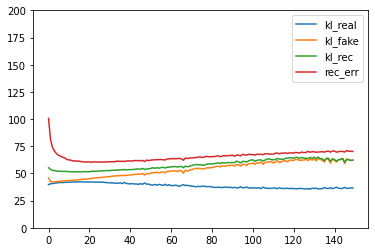

In [7]:
# hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
num_epochs = 150
lr = 2e-4
batch_size = 32
beta_kl = 1.0
beta_rec = 1.0
beta_neg = 256
model = train_soft_intro_vae(dataset='cifar10', z_dim=128, lr_e=2e-4, lr_d=2e-4, batch_size=batch_size,
                             num_workers=0, start_epoch=0, num_epochs=num_epochs, num_vae=0, save_interval=5000,
                             recon_loss_type="mse", beta_kl=beta_kl, beta_rec=beta_rec, beta_neg=beta_neg,
                             test_iter=1000, seed=-1, pretrained=None, device=device)

Note that these results are for 150 epochs, usually more is needed.


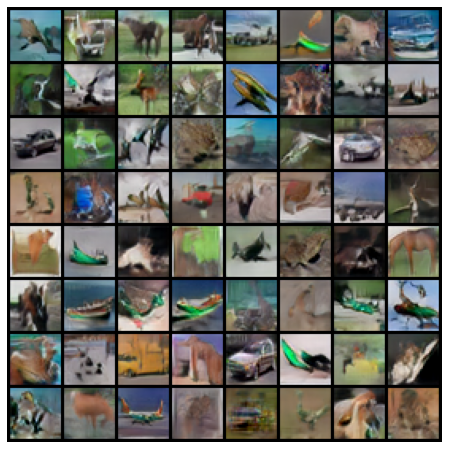

In [16]:
# generate samples
print("Note that these results are for 150 epochs, usually more is needed.")
num_samples = 64
with torch.no_grad():
    noise_batch = torch.randn(size=(num_samples, model.zdim)).to(device)
    images = model.sample(noise_batch)
    images = images.data.cpu().numpy()
    images = np.clip(images * 255, 0, 255).astype(np.uint8)
    images = images / 255.0
    images = torch.from_numpy(images).type(torch.FloatTensor)
    grid = make_grid(images, nrow=8)
    
grid_np = grid.permute(1, 2, 0).data.cpu().numpy()   
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.imshow(grid_np)
ax.set_axis_off()
plt.savefig('cifa10_grid_generated.png')
plt.show()

In [14]:
# reconstructions
num_recon = 8
test_dataset = CIFAR10(root='./cifar10_ds', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(dataset=test_dataset, batch_size=num_recon, shuffle=True)
test_images = iter(test_loader)

Files already downloaded and verified


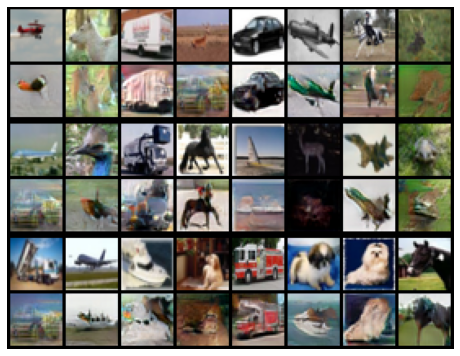

In [15]:
with torch.no_grad():
    total_grid = []
    for _ in range(3):
        data = next(test_images)
        recon = model(data[0].to(device), deterministic=True)[3]
        images = recon.data.cpu().numpy()
        images = np.clip(images * 255, 0, 255).astype(np.uint8)
        images = images / 255.0
        images = torch.from_numpy(images).type(torch.FloatTensor)
        grid = make_grid(torch.cat([data[0], images], dim=0), nrow=8)
        total_grid.append(grid)
    
total_grid = torch.cat(total_grid, dim=1)
grid_np = total_grid.permute(1, 2, 0).data.cpu().numpy()  
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.imshow(grid_np)
ax.set_axis_off()
plt.savefig('cifa10_grid_reconstructions.png')
plt.show()

### <img src="https://img.icons8.com/nolan/64/more.png" style="height:50px;display:inline"> But Wait, There is More...
---
* Soft-IntroVAE Tutorials
    * [Soft-IntroVAE for 2D Datasets]()
    * [Bootstrap Soft-IntroVAE]()
* General Tutorials (Jupyter Notebooks with code)
    * [CS236756 - Intro to Machine Learning](https://github.com/taldatech/cs236756-intro-to-ml)
    * [EE046202 - Unsupervised Learning and Data Analysis](https://github.com/taldatech/ee046202-unsupervised-learning-data-analysis)
    * [EE046746 - Computer Vision](https://github.com/taldatech/ee046746-computer-vision)

## <img src="https://img.icons8.com/dusk/64/000000/prize.png" style="height:50px;display:inline"> Credits
---
* Icons from <a href="https://icons8.com/">Icon8.com</a> - https://icons8.com
